# Learning with backprop and generalisation in multi-layer perceptron

This exercise is concerned with supervised learning approaches for feed-forward multilayer networks - MLP (MLPs)



## Classification and regression with a two-layer perceptron

### Classification of linearly non-separable data


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.colors as clr


# Sigmoid function with range [-1, 1]
def sigmoid(x):
    return 2 / (1 + np.exp(-x)) - 1


# Gives the derivative of the sigmoid function
def sigmoid_derivative(x):
    return 0.5 * ((1 + sigmoid(x)) * (1 - sigmoid(x)))


# Forward propagation
def forward(X, first_layer, hidden_layer):
    # Output first layer
    WX = first_layer.dot(X)
    H = sigmoid(WX)
    # Output second layer
    H = np.vstack([H, np.ones(np.shape(H)[1])])  # Add bias
    VH = hidden_layer.dot(H)
    # Predicted output
    O = sigmoid(VH)
    return O, H


# Backward propagation --> Just check how the error changes w.r.t the weights
def backward(T, O, H, V, Nhidden):
    # Delta error output layer
    delta_o = (O - T) * (sigmoid_derivative(O))
    # Delta error hidden layer
    delta_h = np.dot(V.T, delta_o) * (sigmoid_derivative(H))
    # Remove bias
    delta_h = delta_h[0:Nhidden]
    return delta_o, delta_h


# Update the weights
def weightUpdate(delta_o, delta_h, X, H, W, V, eta, dw, dv, alpha):
    # Dw = momentum * dw - (1 - momentum) * (delta_h.dot(X.T))
    dw = alpha * dw - (1 - alpha) * (delta_h.dot(X.T))
    # Update the weights
    W = W + eta * dw
    V = V + eta * dv
    return W, V, dw, dv


def backpropagation(X, T, W, V, eta, epochs, Nhidden, alpha=0.9):
    errors_list = []
    misclassifications_list = []

    dw = np.ones(np.shape(W))
    dv = np.ones(np.shape(V))

    all_weights1 = []
    all_weights2 = []

    # Loop over the epochs
    for i in range(epochs):
        all_weights1.append(W)
        all_weights2.append(V)
        O, H = forward(X, W, V)

        number_misclassifications = np.shape(X)[1] - np.sum(np.round(O) == T)
        ratio = number_misclassifications / (np.shape(X)[1])

        misclassifications_list.append(ratio)
        errors_list.append(np.mean(np.square(O - T)))
        delta_o, delta_h = backward(T, O, H, V, Nhidden)
        W, V, dw, dv = weightUpdate(delta_o, delta_h, X, H, W, V, eta, dw, dv, alpha)

    all_weights1.append(W)
    all_weights2.append(V)
    return W, V, errors_list, misclassifications_list, all_weights1, all_weights2


# Predict the output
def predict(data, weights, hidden_weights, clasification=True):
    output, _ = forward(data, weights, hidden_weights)
    if clasification:
        output[output >= 1] = 1
        output[output < 0] = -1
    return output


# Tests the model
def test(X, T, epochs, first_layer, hidden_layer):
    errors_list_test = []
    misclassifications_list_test = []
    for i in range(epochs):
        O, H = forward(X, first_layer[i], hidden_layer[i])
        number_misclassifications = np.shape(X)[1] - np.sum(np.round(O) == T)
        ratio = number_misclassifications / (np.shape(X)[1])
        misclassifications_list_test.append(ratio)
        errors_list_test.append(np.mean(np.square(O - T)))
    return errors_list_test, misclassifications_list_test


def plot_decision_boundary(patterns, T, first_layer, second_layer, points=True, h=0.1):
    # Minimum and maximum values for the two input variables
    x_min, x_max = patterns[0, :].min() - 1, patterns[0, :].max() + 1
    y_min, y_max = patterns[1, :].min() - 1, patterns[1, :].max() + 1

    # Create a meshgrid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    grid_data = np.transpose(np.c_[xx.ravel(), yy.ravel()])
    ones = np.transpose(np.ones((np.shape(xx)[1] * np.shape(xx)[0], 1)))
    grid_data = np.vstack((grid_data, ones))
    Z = predict(grid_data, first_layer, second_layer)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    if points:
        plt.scatter(
            patterns[0, :],
            patterns[1, :],
            c=T,
            cmap=clr.ListedColormap(["red", "green"]),
        )
    plt.show()

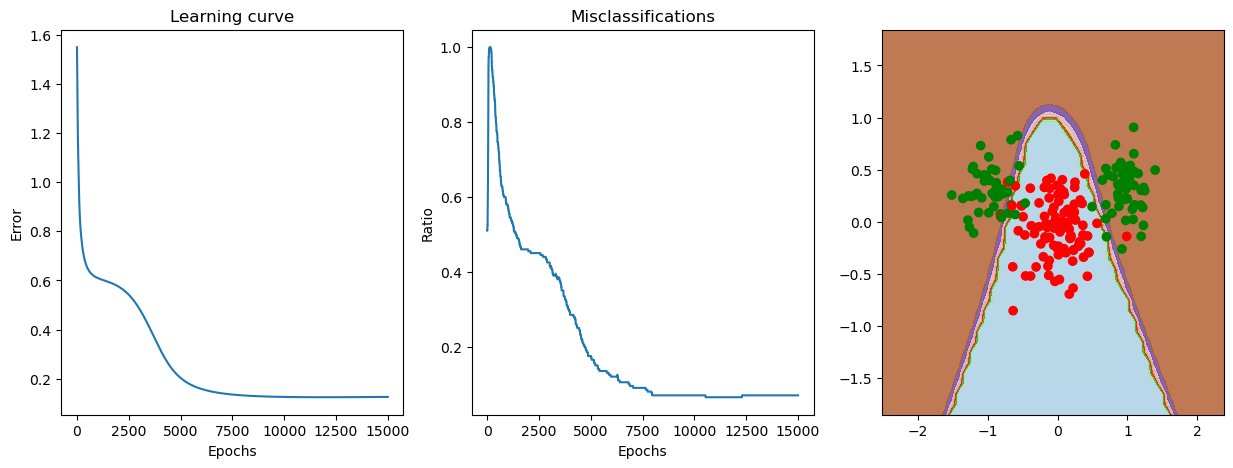

In [8]:
mA = [1, 0.3]
sigmaA = 0.2
mB = [0, -0.1]
sigmaB = 0.3

# Backpropagation parameters
epochs = 15000
eta = 0.0005
Nhidden = 5


# Generate the classes. 2 dimensional with 100 points each
classA = np.zeros((2, 100))
classB = np.zeros((2, 100))

classA[0] = np.concatenate(
    (
        np.random.randn(1, int(0.5 * 100)) * sigmaA - mA[0],
        np.random.randn(1, int(0.5 * 100)) * sigmaA + mA[0],
    ),
    axis=1,
)
classB[0] = np.random.randn(1, 100) * sigmaB + mB[0]
classA[1] = np.random.randn(1, 100) * sigmaA + mA[1]
classB[1] = np.random.randn(1, 100) * sigmaB + mB[1]
classA = classA.T
classB = classB.T
np.random.shuffle(classA)
np.random.shuffle(classB)
classA = classA.T
classB = classB.T

# Creating the dataset
dataset = np.concatenate((classA, classB), axis=1)
dataset = np.concatenate((dataset, np.ones((1, np.shape(dataset)[1]))))
targets = np.concatenate((np.ones(np.shape(classA)[1]), -np.ones(np.shape(classB)[1])))
s = np.arange(dataset.shape[1])

# SHuffle the dataset
np.random.shuffle(s)
patterns = dataset[:, s]
targets = targets[s]

# Initialize the weights
weights1 = np.random.randn(Nhidden, np.shape(patterns)[0])
weights2 = np.random.randn(1, Nhidden + 1)

(
    W,
    V,
    errors_list,
    misclassifications_list,
    all_weights1,
    all_weights2,
) = backpropagation(
    patterns, targets, weights1, weights2, eta, epochs, Nhidden, alpha=0.9
)

# Create 1 x 3 subplots. One with the learning curve and one with decision boundary and one with missclassifications
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(errors_list)
axs[0].set_title("Learning curve")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Error")

axs[1].plot(misclassifications_list)
axs[1].set_title("Misclassifications")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Ratio")

axs[2].plot = plot_decision_boundary(patterns, targets, points=True)
axs[2].set_title("Decision boundary")
axs[2].set_xlabel("x")
axs[2].set_ylabel("y")
plt.show()




### Question 1: 
Modify the number of hidden nodes and demonstrate the effect the size
of the hidden layer has on the performance (both the mean squared error and the number/ratio of misclassifications). How many hidden nodes do you need to perfectly separate all the available data (if manageable at all given your data randomisation)?

**Answer**
A low ETA is good as it prevents overshooting. If we add more hidden nodes then less inputs will be missclassifed HOWEVER this could be due to overfitting. More nodes = More complex = More higher accuracy however if we were to try with validation set then it would be less accurate.

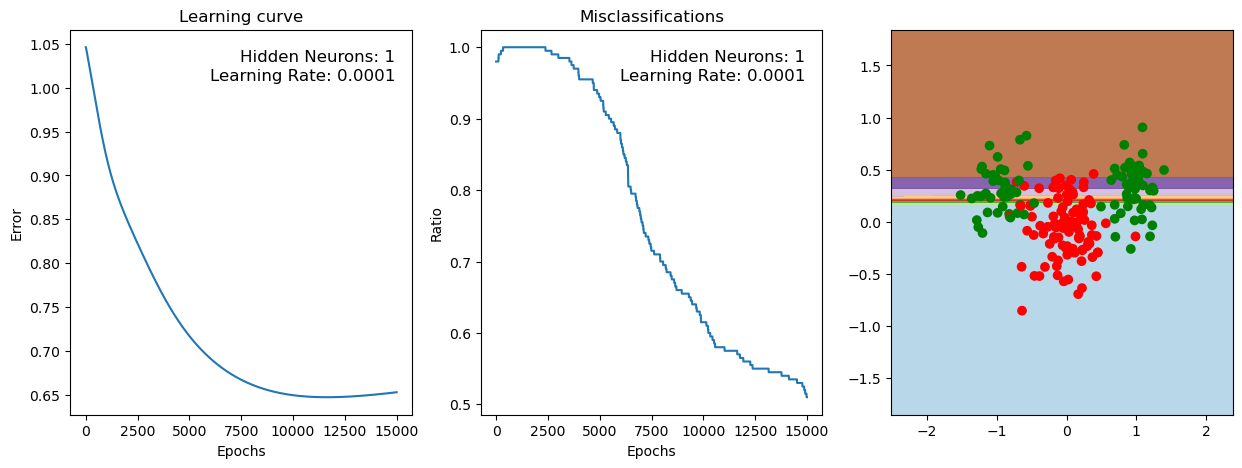

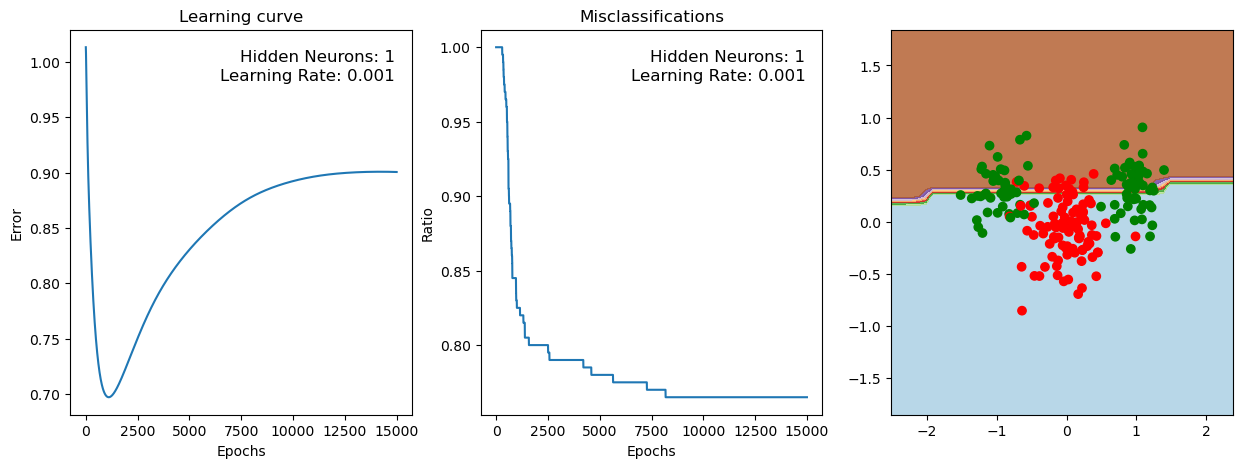

C:\Users\rakin\AppData\Local\Temp\ipykernel_5560\1265280539.py:9: RuntimeWarning: overflow encountered in exp
  return 2 / (1 + np.exp(-x)) - 1


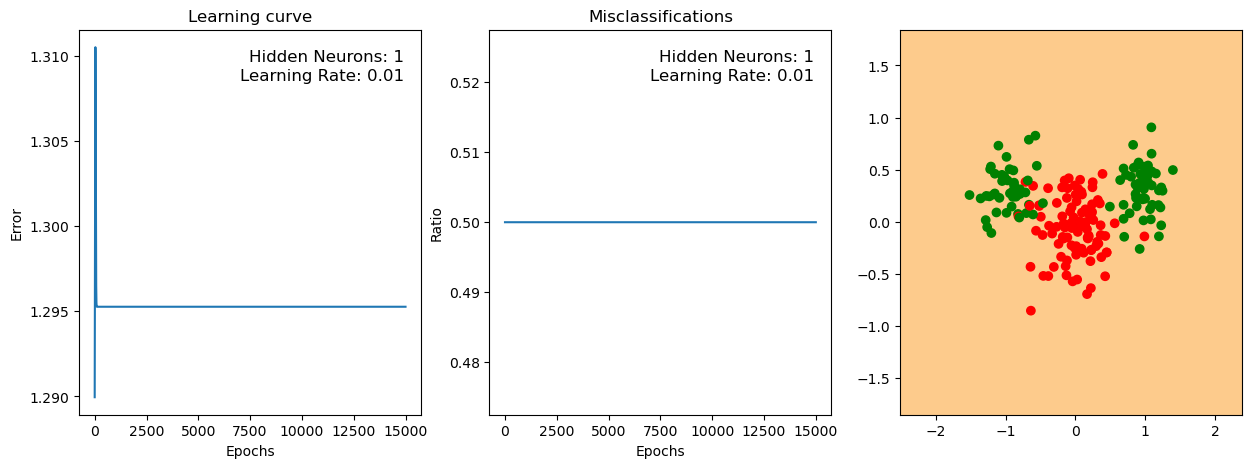

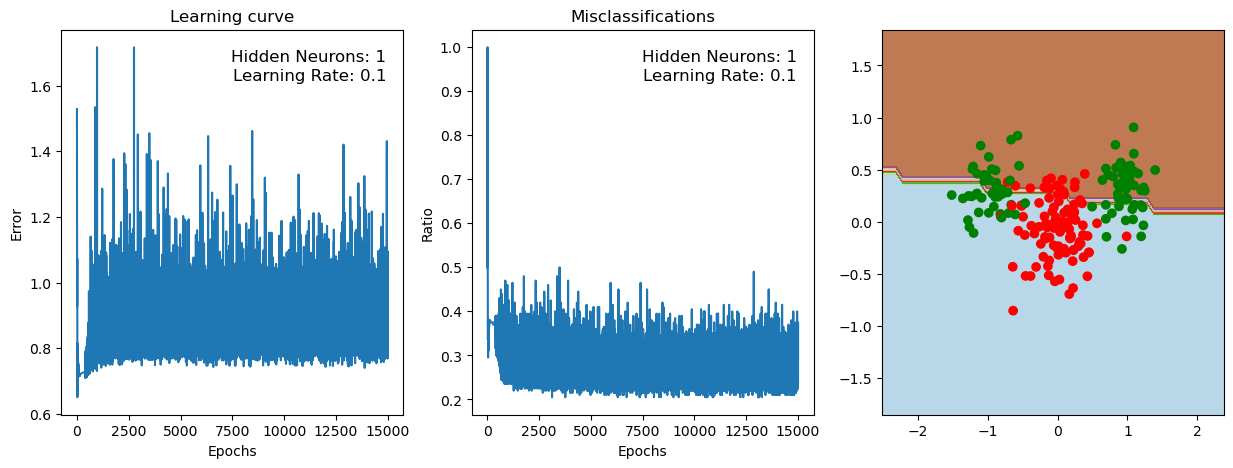

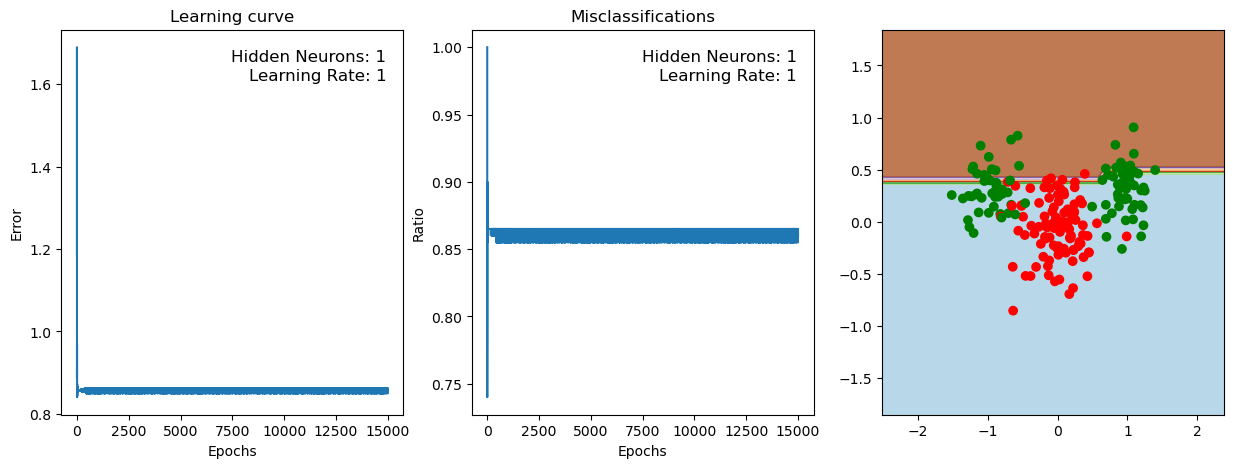

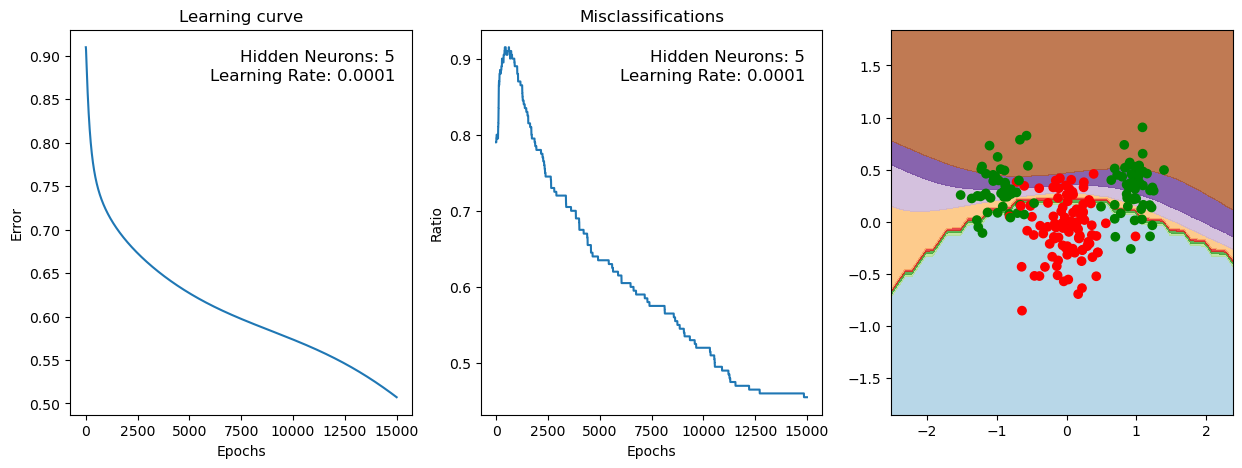

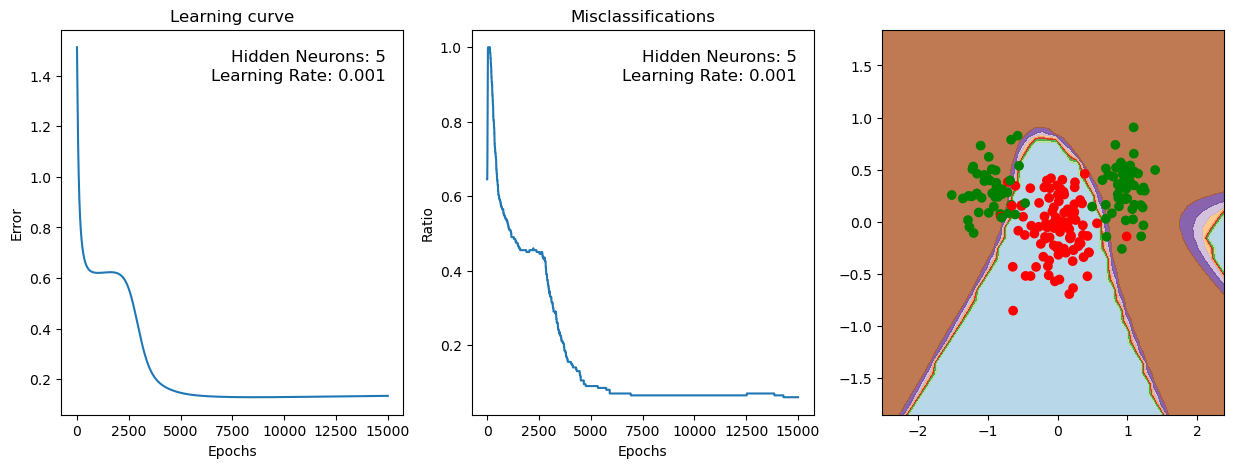

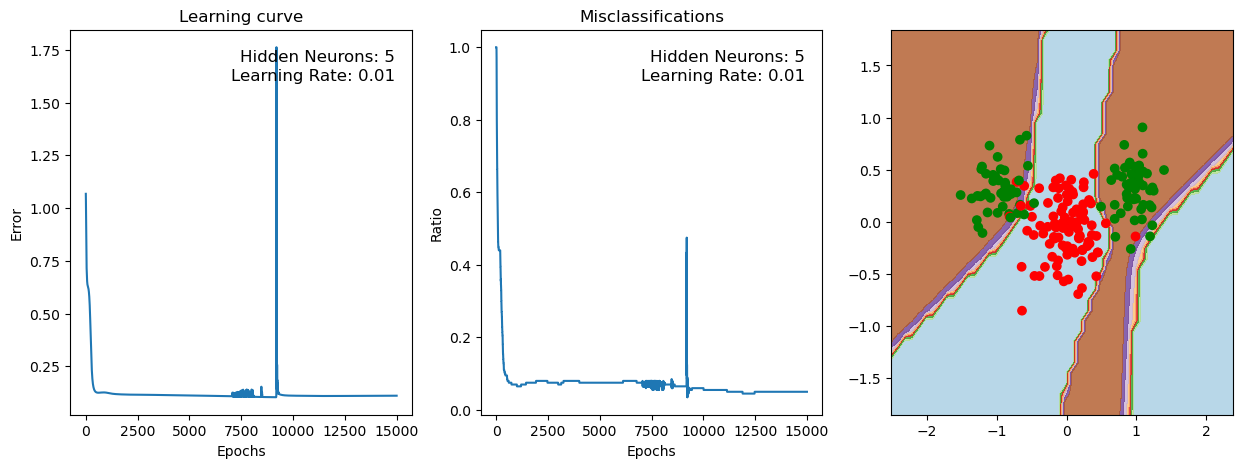

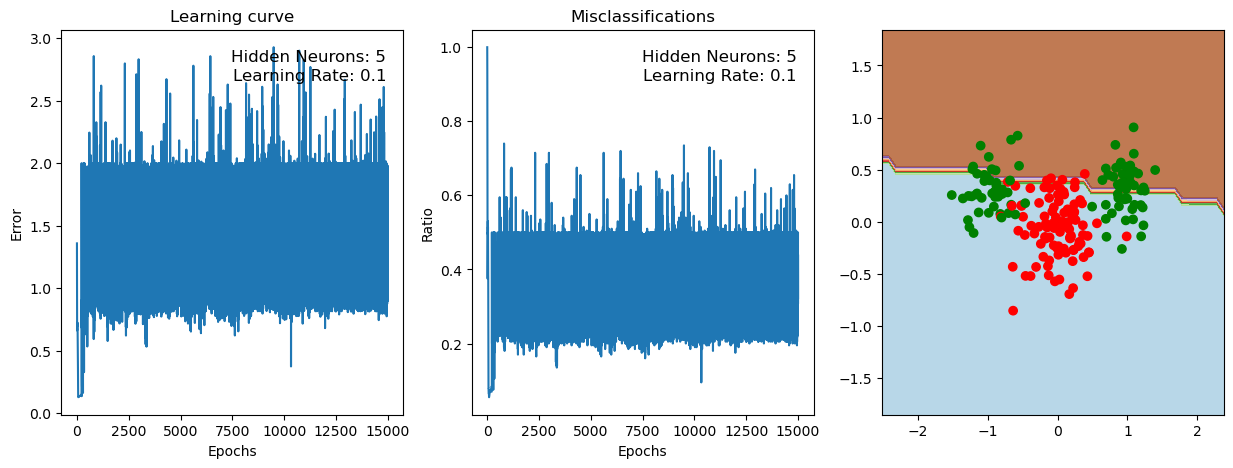

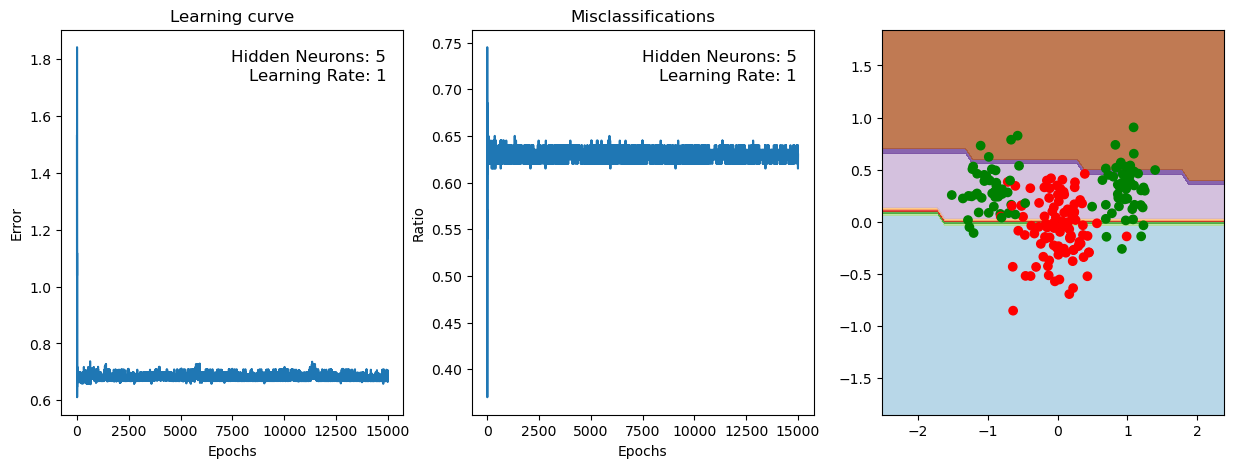

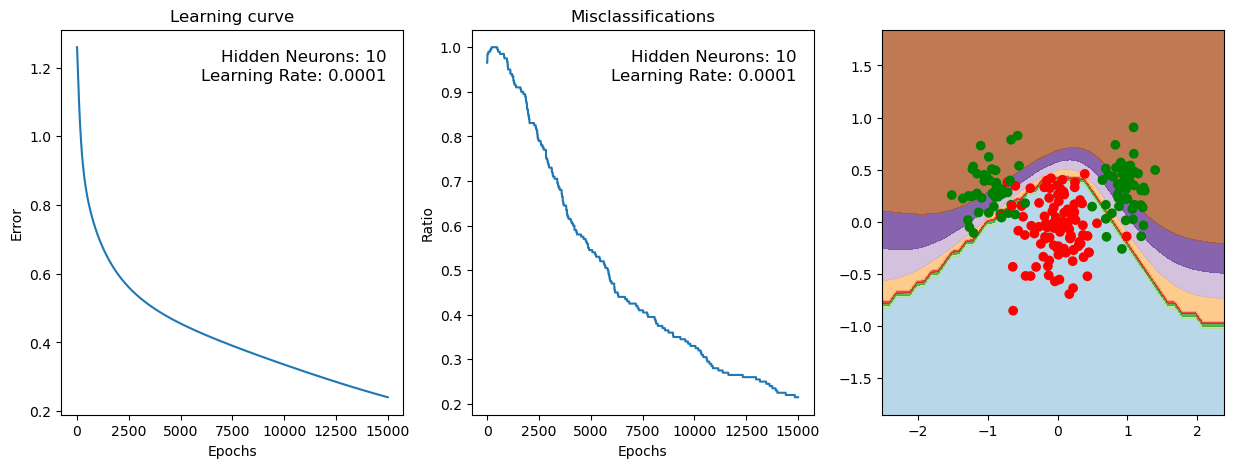

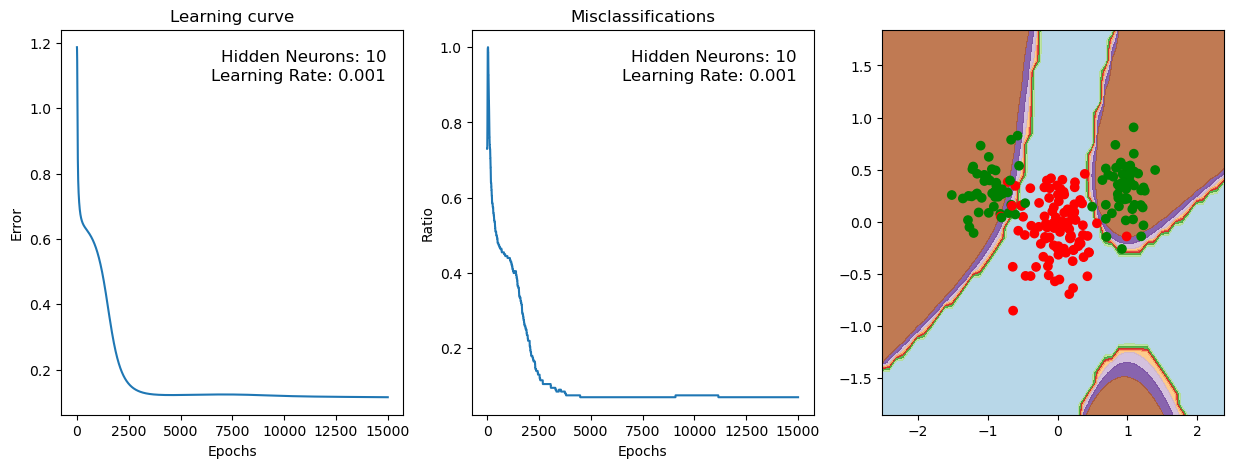

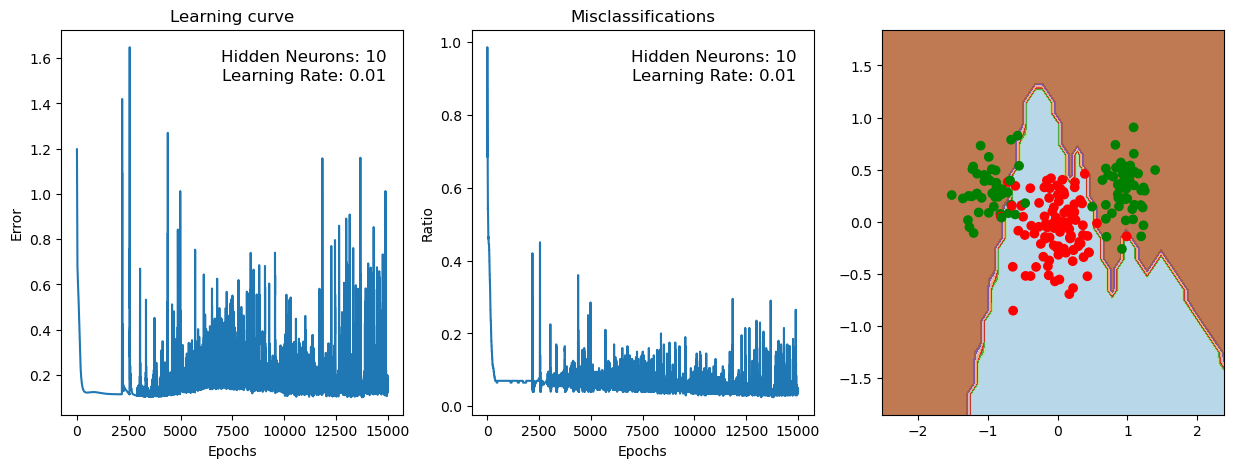

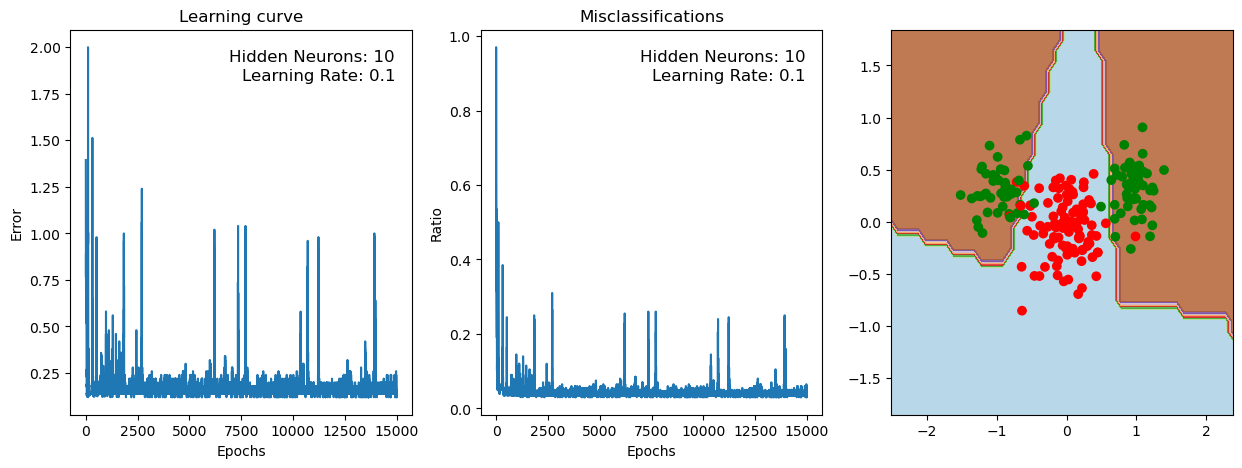

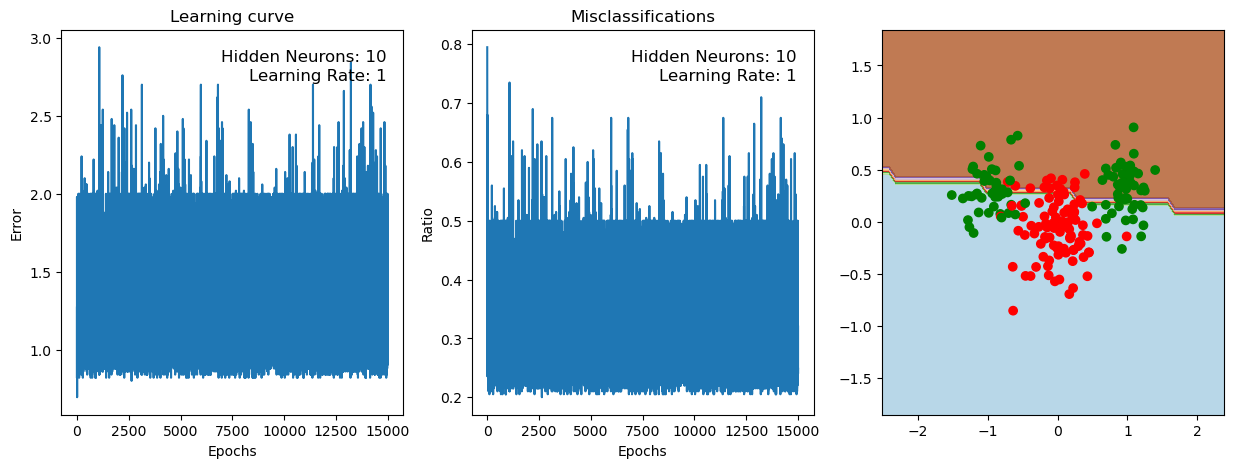

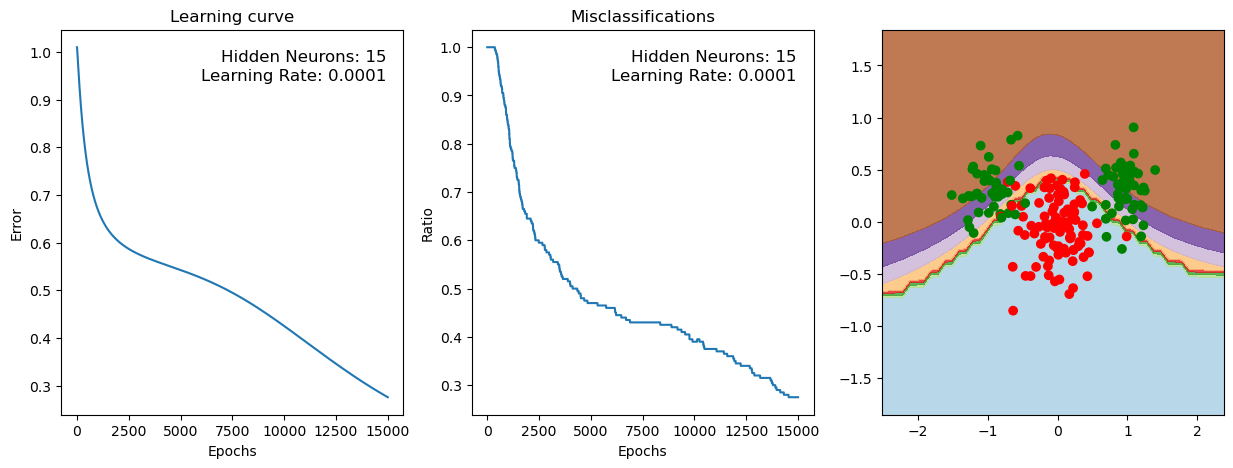

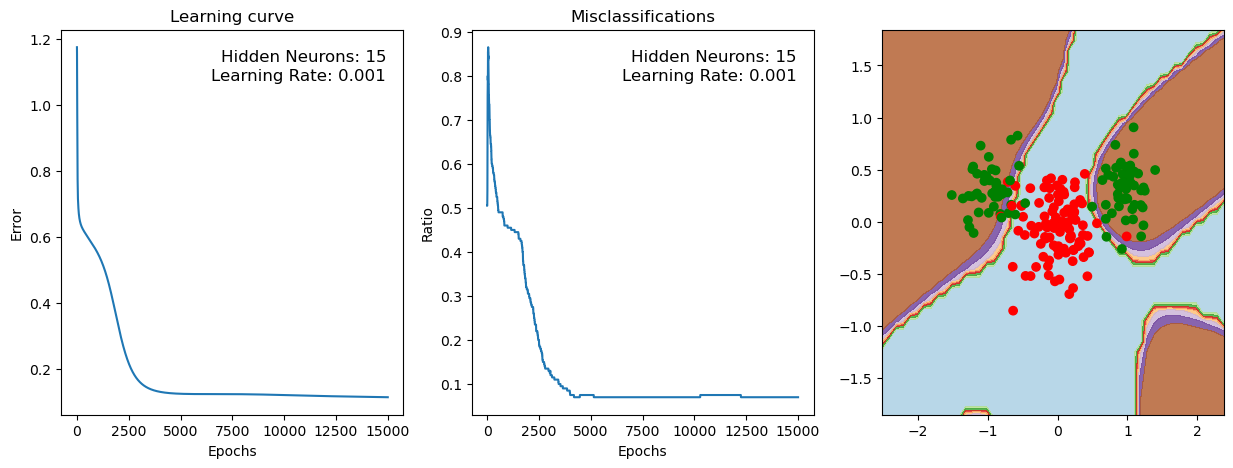

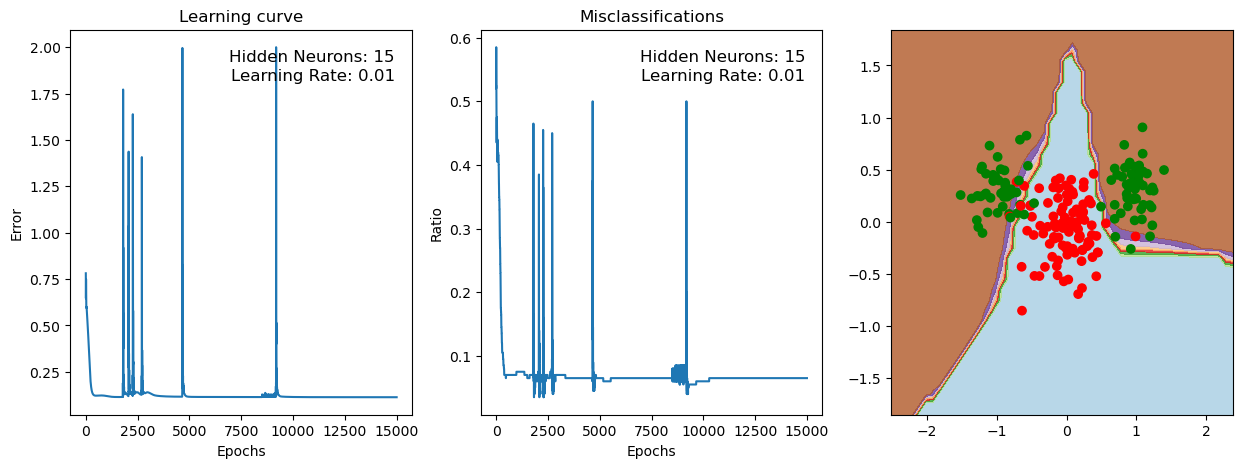

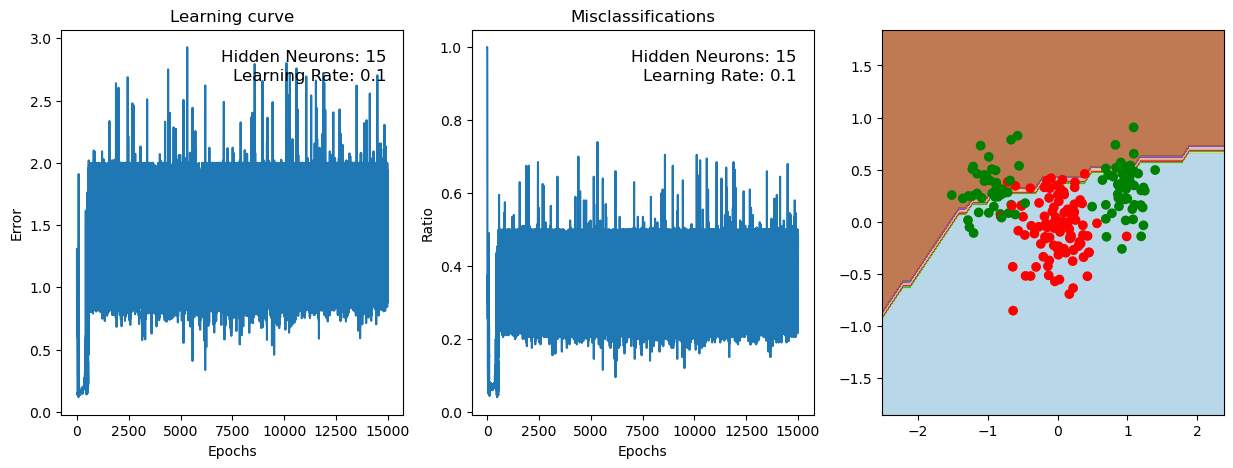

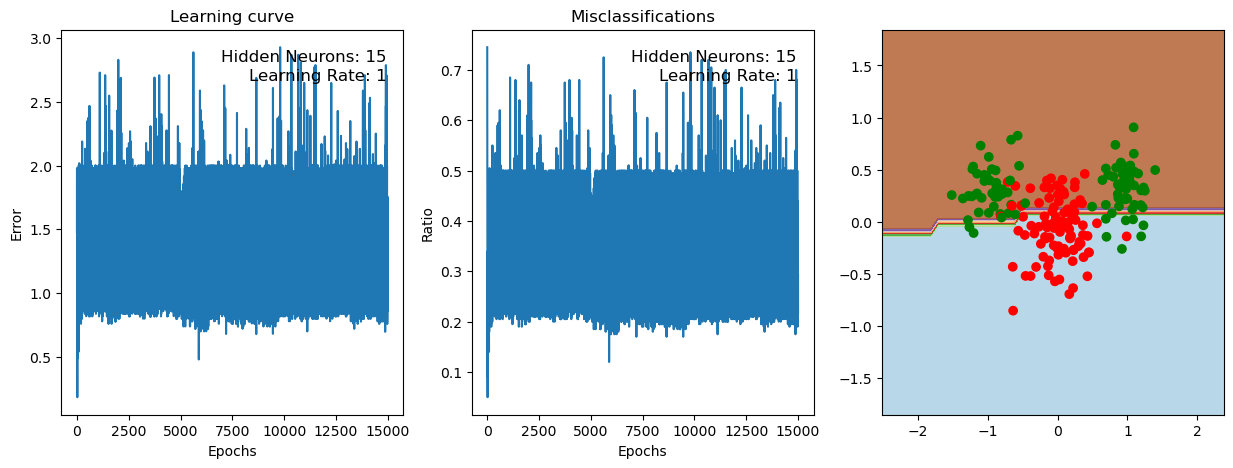

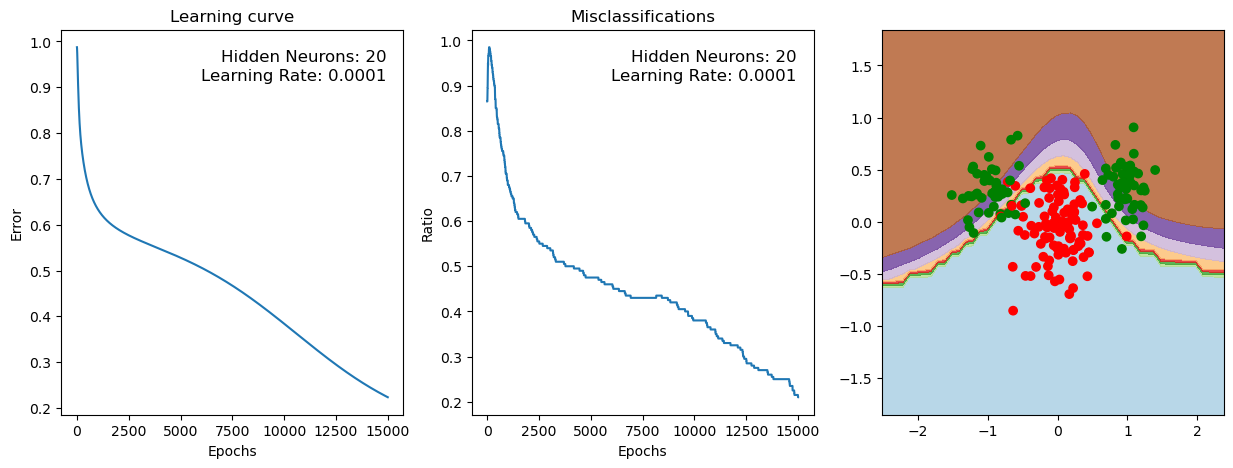

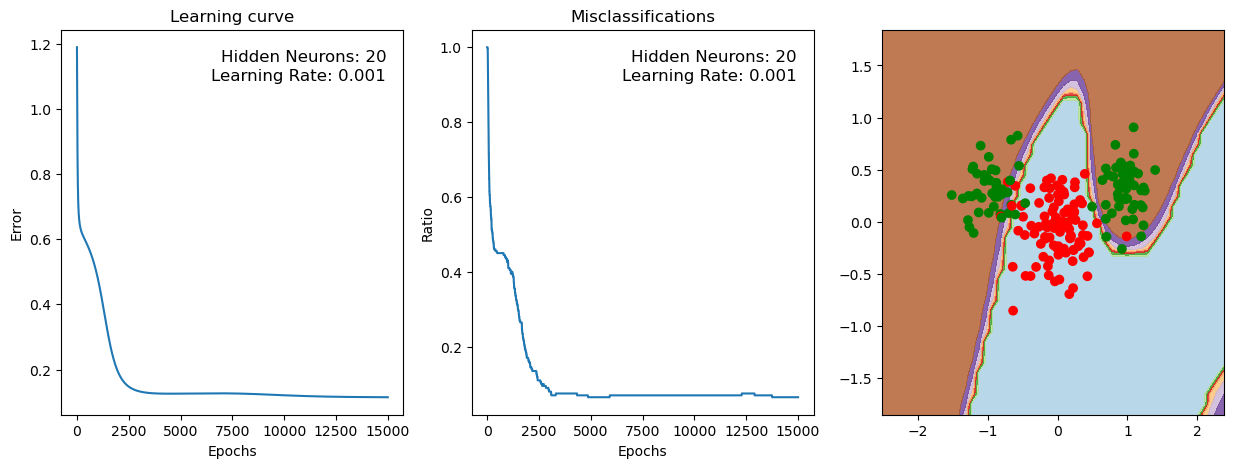

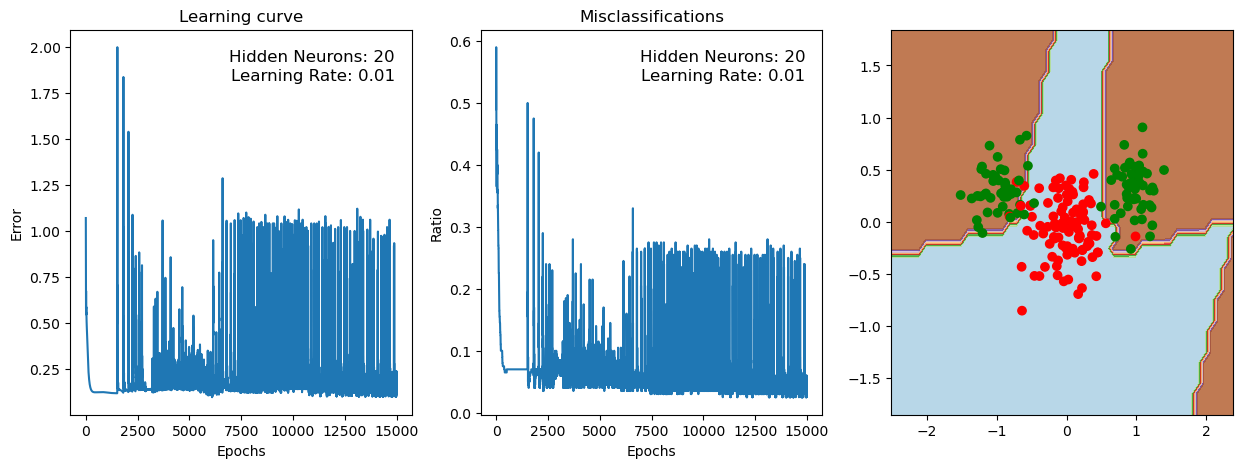

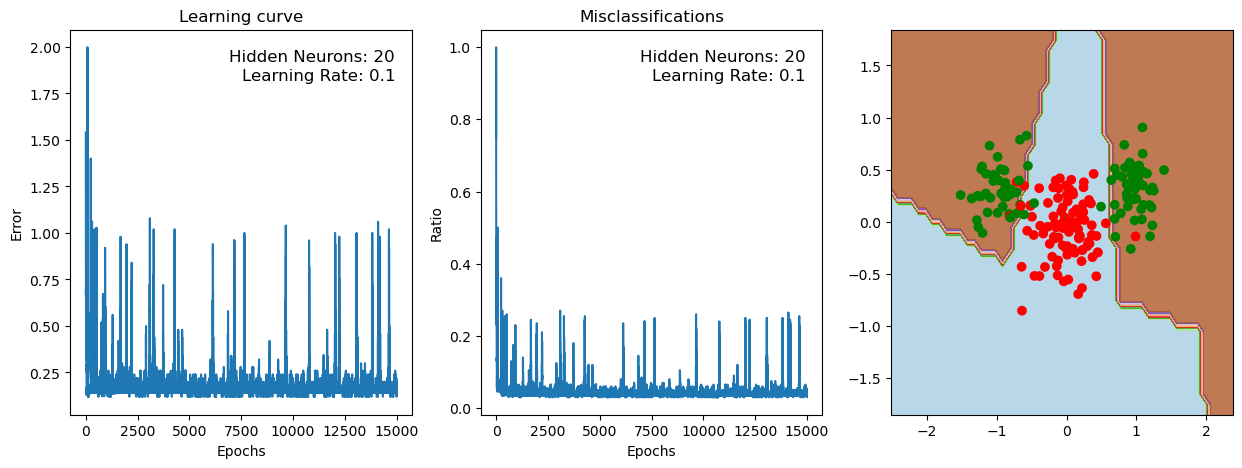

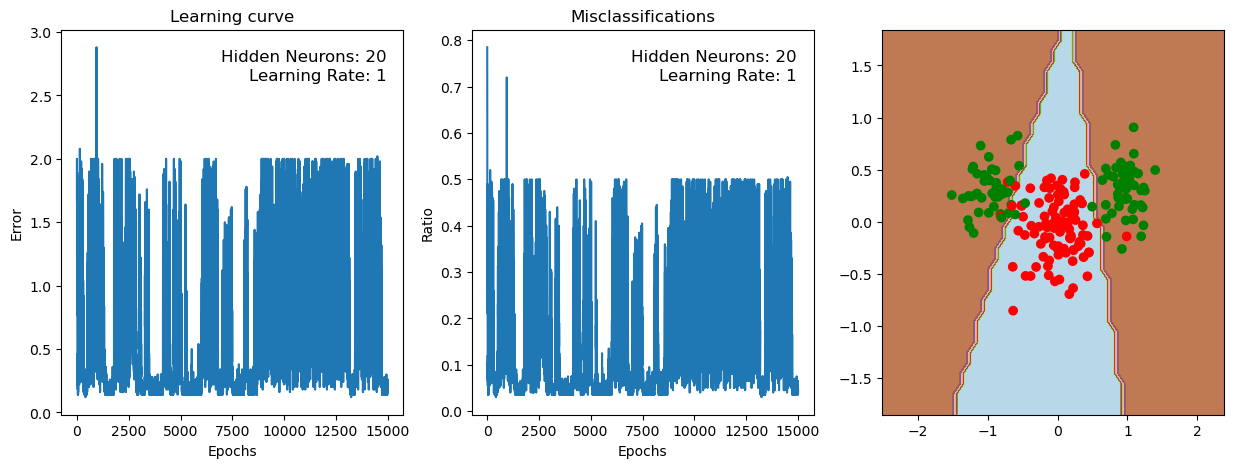

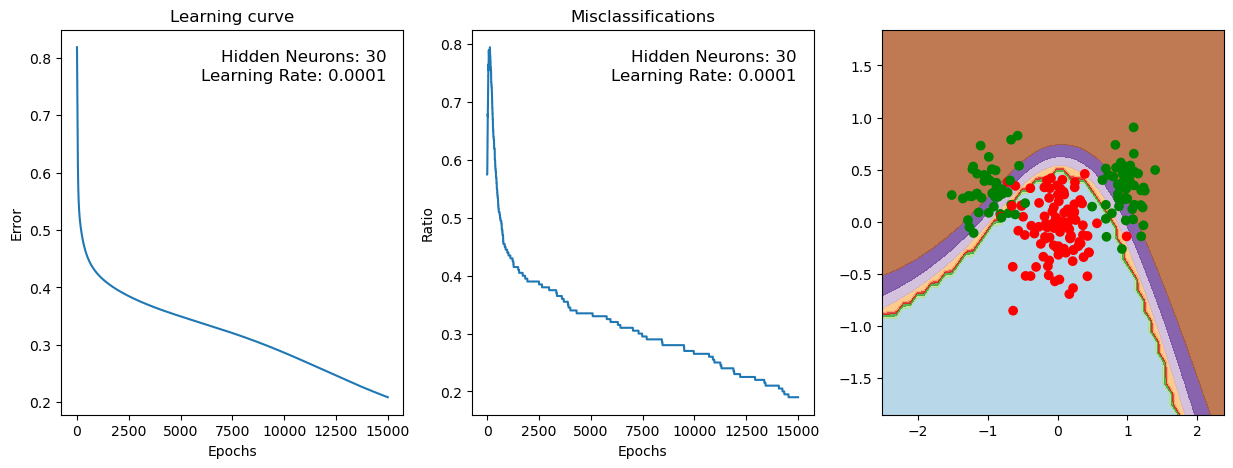

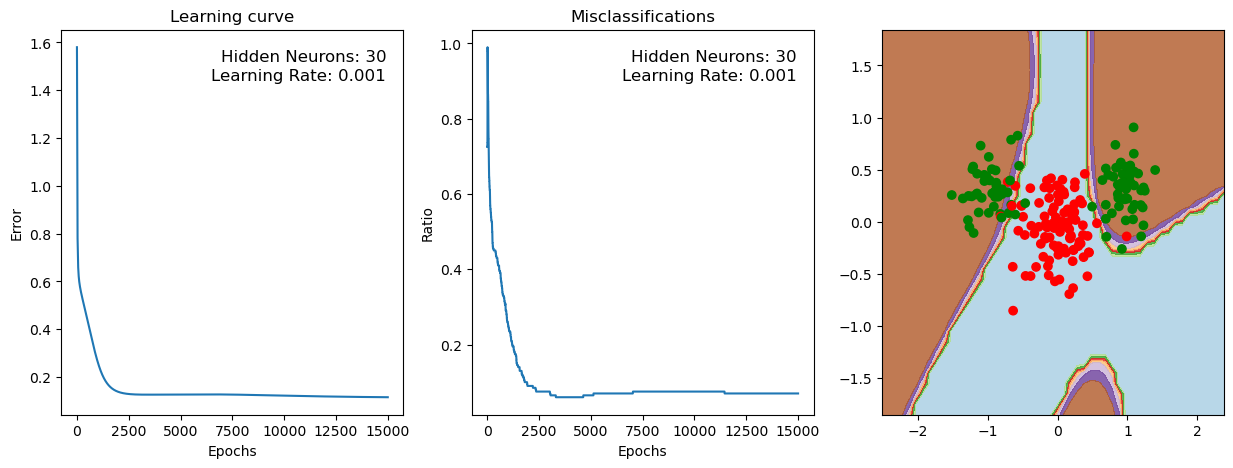

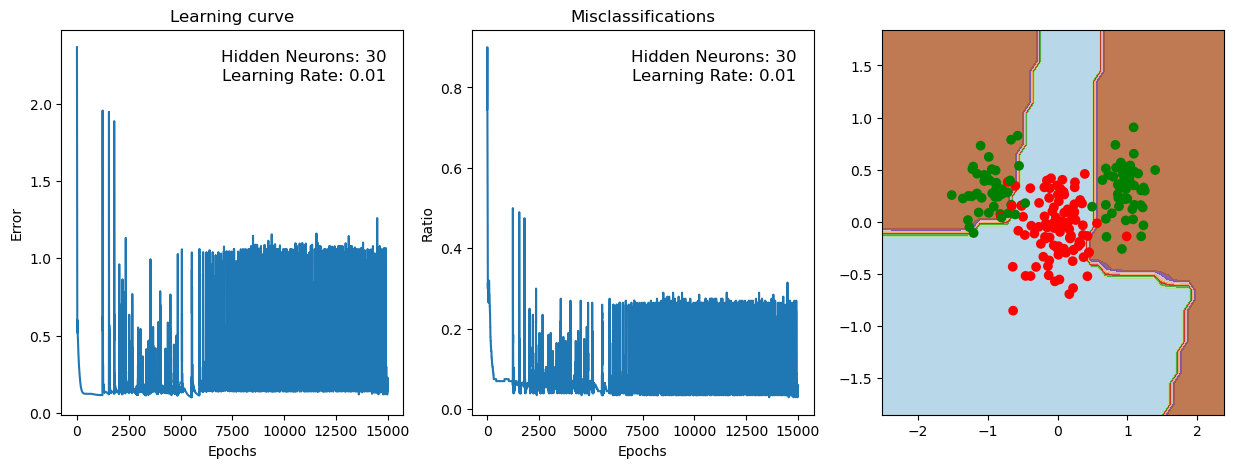

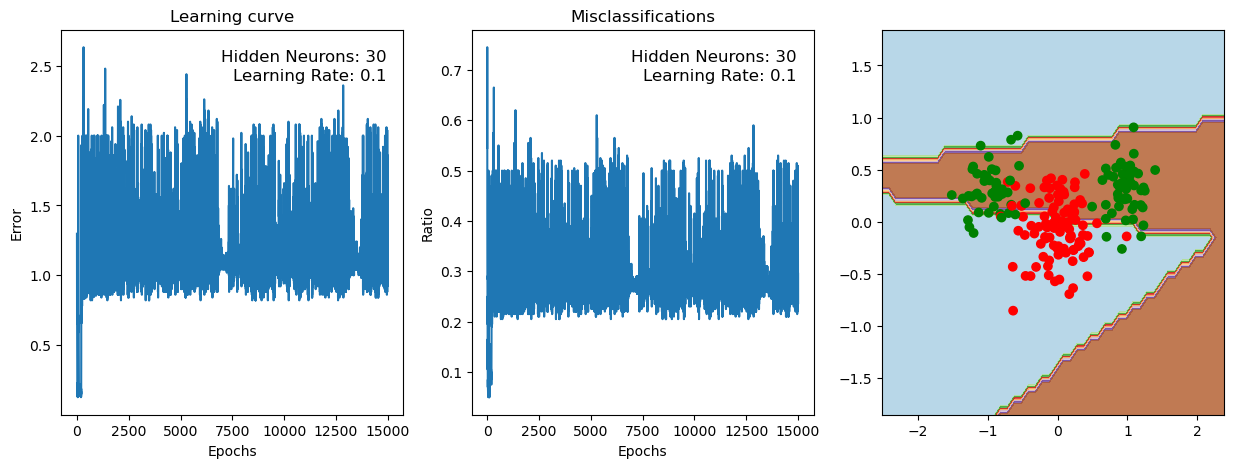

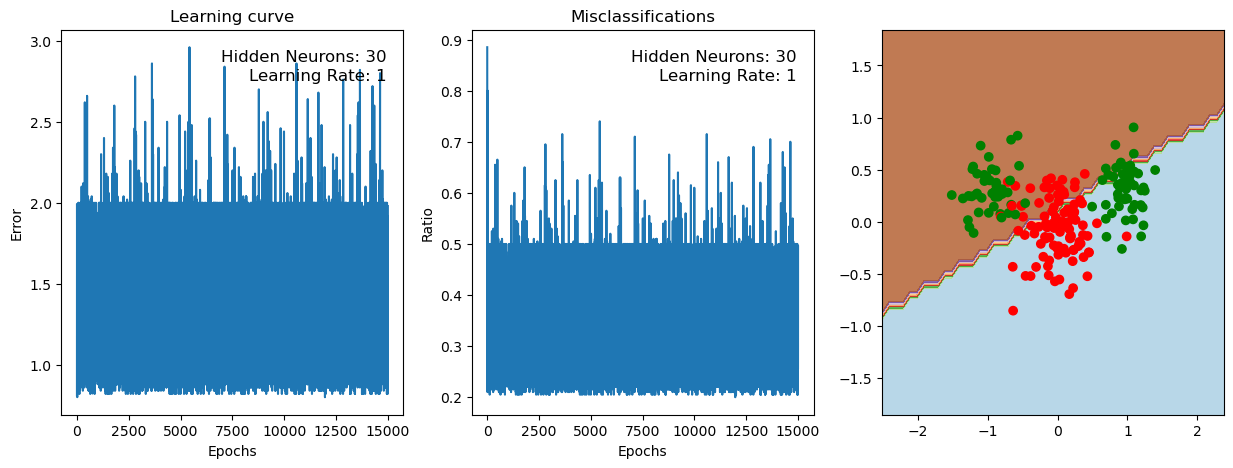

In [9]:
test_hidden_neurons = [1, 5, 10, 15, 20, 30]
test_learning_rates = [0.0001, 0.001, 0.01, 0.1, 1]

for hidden_neurons in test_hidden_neurons:
    for learning_rate in test_learning_rates:
        # Initialize the weights
        weights1 = np.random.randn(hidden_neurons, np.shape(patterns)[0])
        weights2 = np.random.randn(1, hidden_neurons + 1)

        (
            W,
            V,
            errors_list,
            misclassifications_list,
            all_weights1,
            all_weights2,
        ) = backpropagation(
            patterns,
            targets,
            weights1,
            weights2,
            learning_rate,
            epochs,
            hidden_neurons,
            alpha=0.9,
        )

        # Create 1 x 3 subplots. One with the learning curve and one with decision boundary and one with missclassifications
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].plot(errors_list)
        axs[0].set_title("Learning curve")
        axs[0].set_xlabel("Epochs")
        axs[0].set_ylabel("Error")
        axs[0].text(
            0.95,
            0.95,
            f"Hidden Neurons: {hidden_neurons}",
            transform=axs[0].transAxes,
            fontsize=12,
            ha="right",
            va="top",
        )
        axs[0].text(
            0.95,
            0.9,
            f"Learning Rate: {learning_rate}",
            transform=axs[0].transAxes,
            fontsize=12,
            ha="right",
            va="top",
        )

        axs[1].plot(misclassifications_list)
        axs[1].set_title("Misclassifications")
        axs[1].set_xlabel("Epochs")
        axs[1].set_ylabel("Ratio")
        axs[1].text(
            0.95,
            0.95,
            f"Hidden Neurons: {hidden_neurons}",
            transform=axs[1].transAxes,
            fontsize=12,
            ha="right",
            va="top",
        )
        axs[1].text(
            0.95,
            0.9,
            f"Learning Rate: {learning_rate}",
            transform=axs[1].transAxes,
            fontsize=12,
            ha="right",
            va="top",
        )

        axs[2].plot = plot_decision_boundary(patterns, targets, points=True)
        axs[2].set_title("Decision boundary")
        axs[2].set_xlabel("x")
        axs[2].set_ylabel("y")
        axs[2].text(
            0.95,
            0.95,
            f"Hidden Neurons: {hidden_neurons}",
            transform=axs[2].transAxes,
            fontsize=12,
            ha="right",
            va="top",
        )
        axs[2].text(
            0.95,
            0.9,
            f"Learning Rate: {learning_rate}",
            transform=axs[2].transAxes,
            fontsize=12,
            ha="right",
            va="top",
        )

        plt.show()

## Question 2 
Then, formulate a more realistic problem where only a subset of data
points is available for training a network (data you use to calculate weight updates using backprop) and the remaining samples constitute a validation dataset for probing generalisation capabilites of the network. To do that, subsample the data for training according to the following scenarios:
1.  Random 25 from each class
2. Random 50 from each class
3. 20% from a subset of classA for which classA(1,:)<0 and 80% from a subset of classA for which classA(1,:)>0

The removed samples treat as a validation set. Make sure you do not use this hold-out set in the training process and instead you only use it to calculate the error (mean squared error or the ratio of misclassifications) at different stages/epochs of learning to monitor the progress. In this configuration, you can address the following tasks and questions
- How do the learning/error curves for training and validation sets
compare? Are they similar? When do you observe more dissimilarity?
- How do these curves and the network performance depend on the size
of the hidden layer in various training/validation data configurations (the aforementioned subsampling options)?
- Is there any difference between a batch and sequential learning approach in terms of the validation performance?
- Make an attempt at approximating the resulting decision boundary,
i.e. where the network output is 0 (between the target labels of -1
and 1 for two classes, respectively).


Generating the datasets 

In [10]:
# Split the dataset into training and test set
mA = [1, 0.3]
mB = [0, -0.1]
sigmaA = 0.2
sigmaB = 0.3
classA[0] = np.concatenate(
    (
        np.random.randn(1, int(0.5 * 100)) * sigmaA - mA[0],
        np.random.randn(1, int(0.5 * 100)) * sigmaA + mA[0],
    ),
    axis=1,
)
classB[0] = np.random.randn(1, 100) * sigmaB + mB[0]
classA[1] = np.random.randn(1, 100) * sigmaA + mA[1]
classB[1] = np.random.randn(1, 100) * sigmaB + mB[1]
classA = classA.T
classB = classB.T
np.random.shuffle(classA)
np.random.shuffle(classB)
classA = classA.T
classB = classB.T

In [11]:
# Generates the dataset for the first scenario. Returns the training, test_train, test_data and test_test set
def scenario_1():
    # Remove 25% of the data from class A and B
    classA_train = classA[:, : int(0.75 * 100)]
    classB_train = classB[:, : int(0.75 * 100)]
    classA_test = classA[:, int(0.75 * 100) :]
    classB_test = classB[:, : int(0.75 * 100) :]

    dataset_train = np.concatenate((classA_train, classB_test), axis=1)
    dataset_train = np.concatenate(
        (dataset_train, np.ones((1, np.shape(dataset_train)[1])))
    )

    targets_train = np.concatenate(
        (
            np.ones(int(np.shape(classA_train)[1])),
            -np.ones(int(np.shape(classB_train)[1])),
        )
    )
    # Shuffle the dataset
    s = np.arange(dataset_train.shape[1])
    np.random.shuffle(s)
    dataset_train = dataset_train[:, s]
    targets_train = targets_train[s]

    dataset_test = np.concatenate((classA_test, classB_test), axis=1)
    dataset_test = np.concatenate(
        (dataset_test, np.ones((1, np.shape(dataset_test)[1])))
    )
    targets_test = np.concatenate(
        (
            np.ones(int(np.shape(classA_test)[1])),
            -np.ones(int(np.shape(classB_test)[1])),
        )
    )
    s = np.arange(dataset_test.shape[1])
    np.random.shuffle(s)
    dataset_test = dataset_test[:, s]
    targets_test = targets_test[s]

    return dataset_train, targets_train, dataset_test, targets_test

# Second scenario
def scenario_2():
    classA_train = classA[:, : int(0.5 * 100)]
    classB_train = classB
    classA_test = classA[:, int(0.5 * 100) :]

    dataset_train = np.concatenate((classA_train, classB_train), axis=1)
    dataset_train = np.concatenate(
        (dataset_train, np.ones((1, np.shape(dataset_train)[1])))
    )
    targets_train = np.concatenate(
        (np.ones(np.shape(classA_train)[1]), -np.ones(np.shape(classB_train)[1]))
    )
    s = np.arange(dataset_train.shape[1])
    np.random.shuffle(s)

    dataset_train = dataset_train[:, s]
    targets_train = targets_train[s]

    dataset_test = np.concatenate((classA_test, np.ones((1, np.shape(classA_test)[1]))))
    targets_test = np.ones((np.shape(classA_test)[1]))
    s = np.arange(dataset_test.shape[1])
    np.random.shuffle(s)
    dataset_test = dataset_test[:, s]
    targets_test = targets_test[s]

    return dataset_train, targets_train, dataset_test, targets_test

# Third scenario
def scenario_3():
    j = 0
    k = 0
    neg = np.zeros([2, 100])
    pos = np.zeros([2, 100])
    for i in range(np.shape(classA)[1]):
        if classA[0][i] < 0:
            neg[:, j] = classA[:, i]
            j += 1
        else:
            pos[:, k] = classA[:, i]
            k += 1
    pos = pos[:, :k]
    neg = neg[:, :j]
    pos_train = pos[:, : int(0.2 * np.shape(pos[:, :50])[1])]
    neg_train = neg[:, : int(0.8 * np.shape(neg[:, :50])[1])]
    classA_train = np.concatenate((pos_train, neg_train), axis=1)
    classB_train = classB

    pos_test = pos[:, int(0.2 * np.shape(pos[:, :50])[1]) :]
    neg_test = neg[:, int(0.8 * np.shape(neg[:, :50])[1]) :]
    classA_test = np.concatenate((pos_test, neg_test), axis=1)


    patterns_train = np.concatenate((classA_train, classB_train), axis=1)
    patterns_train = np.concatenate(
        (patterns_train, np.ones((1, np.shape(patterns_train)[1])))
    )
    targets_train = np.concatenate(
        (np.ones(np.shape(classA_train)[1]), -np.ones(np.shape(classB_train)[1]))
    )
    s = np.arange(patterns_train.shape[1])
    np.random.shuffle(s)
    patterns_train = patterns_train[:, s]
    targets_train = targets_train[s]

    patterns_test = np.concatenate((classA_test, np.ones((1, np.shape(classA_test)[1]))))
    targets_test = np.ones((np.shape(classA_test)[1]))
    s = np.arange(patterns_test.shape[1])
    np.random.shuffle(s)
    patterns_test = patterns_test[:, s]
    targets_test = targets_test[s]
    return patterns_train, targets_train, patterns_test, targets_test


dataset_1, targets_1, dataset_test_1, targets_test_1 = scenario_1()
dataset_2, targets_2, dataset_test_2, targets_test_2 = scenario_2()
dataset_3, targets_3, dataset_test_3, targets_test_3 = scenario_3()

Training and testing on each dataset

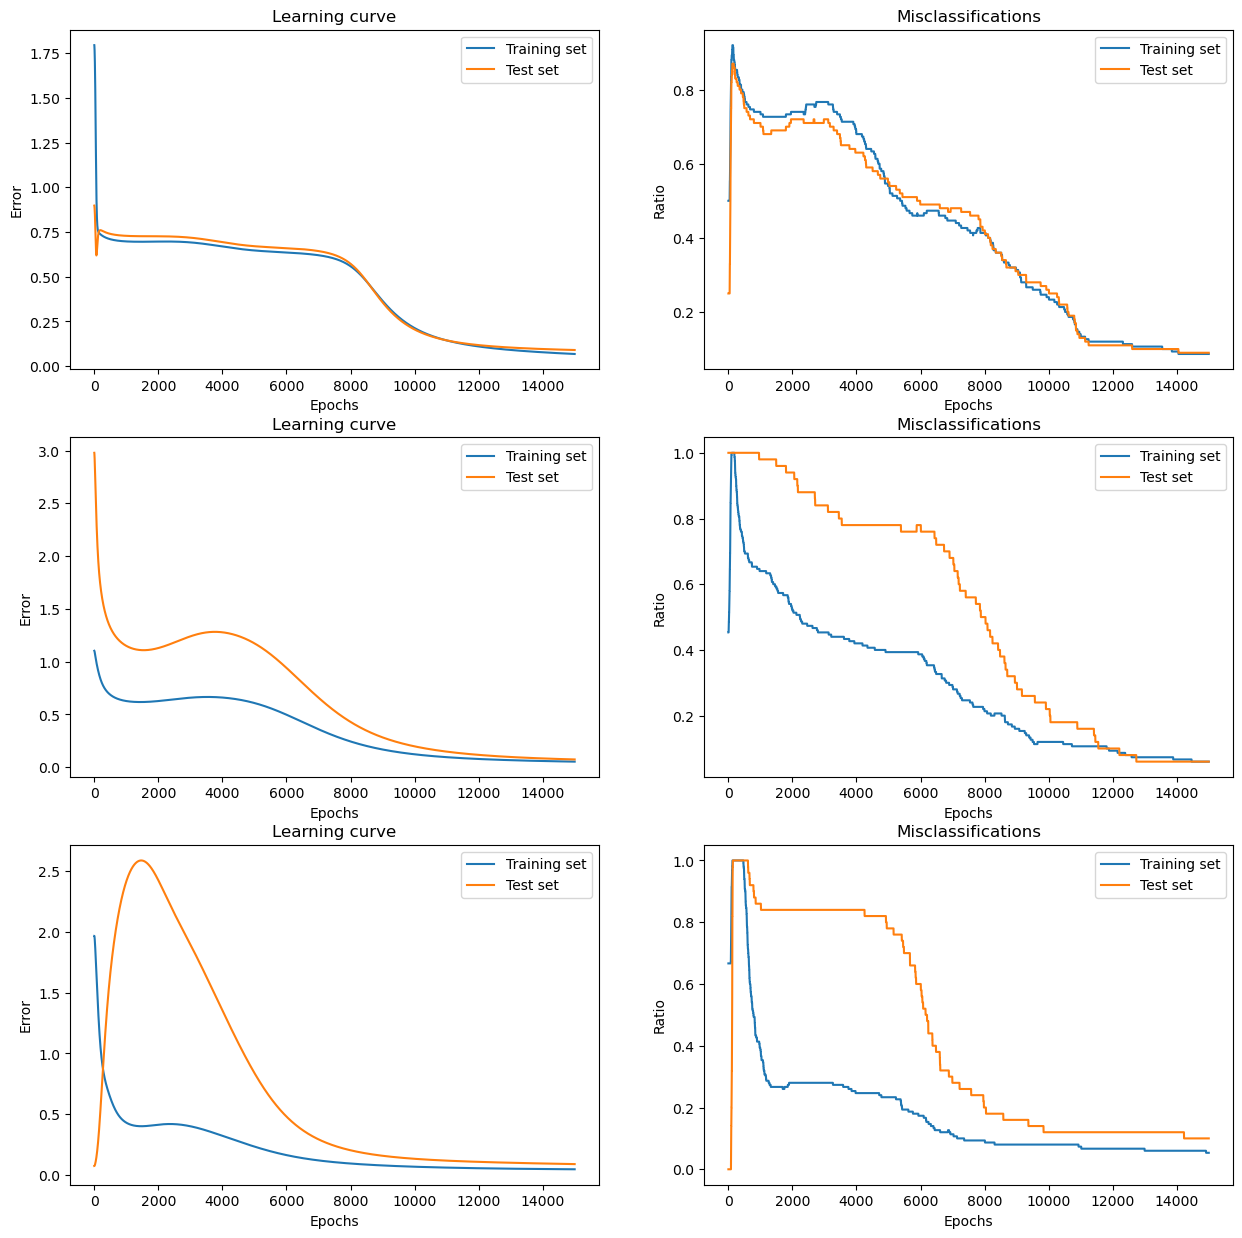

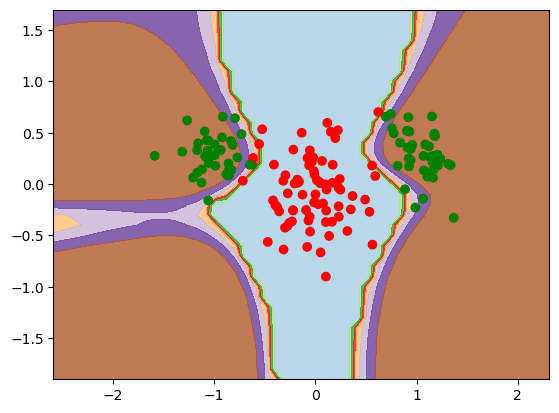

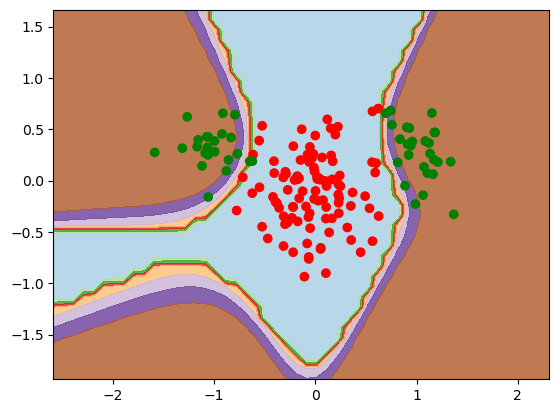

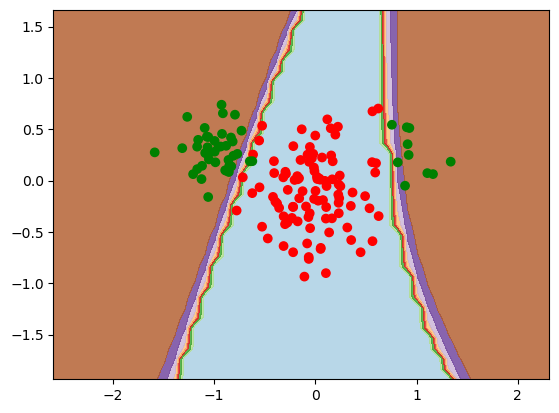

Plotting the decision boundary for the test set


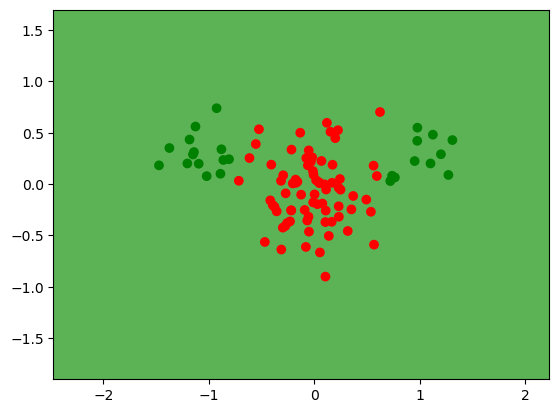

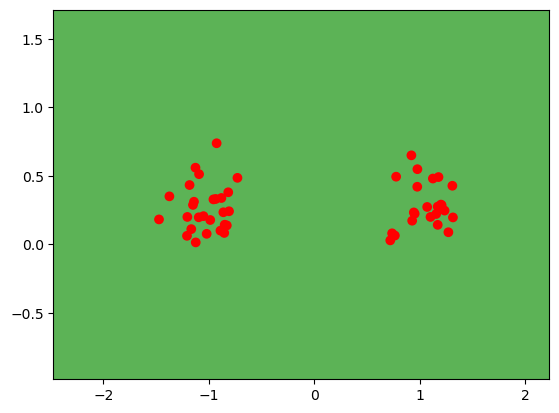

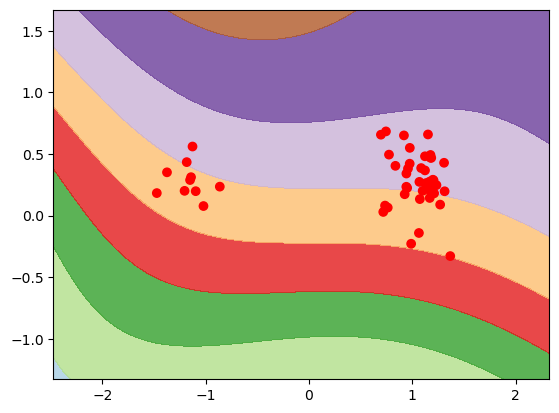

In [30]:
# Scenario 1
weights_1_scenario_1 = np.random.randn(Nhidden, np.shape(dataset_1)[0])
weights_2_scenario_1 = np.random.randn(1, Nhidden + 1)
w1_test_scen1 = np.copy(weights_1_scenario_1)
w2_test_scen1 = np.copy(weights_2_scenario_1)

# Scenario 2
weights_1_scenario_2 = np.random.randn(Nhidden, np.shape(dataset_2)[0])
weights_2_scenario_2 = np.random.randn(1, Nhidden + 1)
w1_test_scen2 = np.copy(weights_1_scenario_2)
w2_test_scen2 = np.copy(weights_2_scenario_2)

# Scenario 3
weights_1_scenario_3 = np.random.randn(Nhidden, np.shape(dataset_3)[0])
weights_2_scenario_3 = np.random.randn(1, Nhidden + 1)
w1_test_scen3 = np.copy(weights_1_scenario_3)
w2_test_scen3 = np.copy(weights_2_scenario_3)

# Train and test the model for scenario 1
(
    w1_done_s1,
    w2_done_s1,
    errors_list_scen1,
    miss_class_scen1,
    all_weights1,
    all_weights2,
) = backpropagation(
    dataset_1, targets_1, weights_1_scenario_1, weights_2_scenario_1, eta, epochs, Nhidden, alpha=0.9
)
# Test the model on the test set
errors_list_test_scen1, miss_class_test_scen1 = test(
    dataset_test_1, targets_test_1, epochs, all_weights1, all_weights2
)

# Train and test the model for scenario 2
(
    w1_done_s2,
    w2_done_s2,
    errors_list_scen2,
    miss_class_scen2,
    all_weights1,
    all_weights2,
) = backpropagation(
    dataset_2, targets_2, weights_1_scenario_2, weights_2_scenario_2, eta, epochs, Nhidden, alpha=0.9
)

errors_list_test_scen2, miss_class_test_scen2 = test(
    dataset_test_2, targets_test_2, epochs, all_weights1, all_weights2
)

# Train and test the model for scenario 3
(
    w1_done_s3,
    w2_done_s3,
    errors_list_scen3,
    miss_class_scen3,
    all_weights1,
    all_weights2,
) = backpropagation(
    dataset_3, targets_3, weights_1_scenario_3, weights_2_scenario_3, eta, epochs, Nhidden, alpha=0.9
)

errors_list_test_scen3, miss_class_test_scen3 = test(
    dataset_test_3, targets_test_3, epochs, all_weights1, all_weights2
)
# Create a 3x3 subplot. One row for each scenario and one column for each plot
# Column 1 is the learning curve on the training and test set 
# Column 2 is the misclassifications on the training and test set 
# Column 3 is the decision boundary on the training set 
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
axs[0, 0].plot(errors_list_scen1)
axs[0, 0].plot(errors_list_test_scen1)
axs[0, 0].set_title("Learning curve")
axs[0, 0].set_xlabel("Epochs")
axs[0, 0].set_ylabel("Error")
axs[0, 0].legend(["Training set", "Test set"])

axs[0, 1].plot(miss_class_scen1)
axs[0, 1].plot(miss_class_test_scen1)
axs[0, 1].set_title("Misclassifications")
axs[0, 1].set_xlabel("Epochs")
axs[0, 1].set_ylabel("Ratio")
axs[0, 1].legend(["Training set", "Test set"])

axs[1, 0].plot(errors_list_scen2)
axs[1, 0].plot(errors_list_test_scen2)
axs[1, 0].set_title("Learning curve")
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].set_ylabel("Error")
axs[1, 0].legend(["Training set", "Test set"])

axs[1, 1].plot(miss_class_scen2)
axs[1, 1].plot(miss_class_test_scen2)
axs[1, 1].set_title("Misclassifications")
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].set_ylabel("Ratio")
axs[1, 1].legend(["Training set", "Test set"])

axs[2, 0].plot(errors_list_scen3)
axs[2, 0].plot(errors_list_test_scen3)
axs[2, 0].set_title("Learning curve")
axs[2, 0].set_xlabel("Epochs")
axs[2, 0].set_ylabel("Error")
axs[2, 0].legend(["Training set", "Test set"])

axs[2, 1].plot(miss_class_scen3)
axs[2, 1].plot(miss_class_test_scen3)
axs[2, 1].set_title("Misclassifications")
axs[2, 1].set_xlabel("Epochs")
axs[2, 1].set_ylabel("Ratio")
axs[2, 1].legend(["Training set", "Test set"])
plt.show()

# Plot the decision boundary for each scenario
plot_decision_boundary(dataset_1, targets_1, w1_done_s1, w2_done_s1, points=True)
plot_decision_boundary(dataset_2, targets_2, w1_done_s2, w2_done_s2, points=True)
plot_decision_boundary(dataset_3, targets_3, w1_done_s3, w2_done_s3, points=True)

print("Plotting the decision boundary for the test set")
plot_decision_boundary(dataset_test_1, targets_test_1, w1_test_scen1, w2_test_scen1, points=True)
plot_decision_boundary(dataset_test_2, targets_test_2, w1_test_scen2, w2_test_scen2, points=True)
plot_decision_boundary(dataset_test_3, targets_test_3, w1_test_scen3, w2_test_scen3, points=True)




